# Lab 1: Scikit-learn #

## KNN ##

In [1]:
import numpy as np
from sklearn import datasets

In [2]:
iris = datasets.load_iris()
iris_X = iris.data
iris_y = iris.target
np.unique(iris_y)

array([0, 1, 2])

In [3]:
np.random.seed(0)
indices = np.random.permutation(len(iris_X))
iris_X_train = iris_X[indices[:-10]]
iris_y_train = iris_y[indices[:-10]]
iris_X_test = iris_X[indices[-10:]]
iris_y_test = iris_y[indices[-10:]]

In [4]:
from sklearn .neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(iris_X_train, iris_y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [5]:
from sklearn . metrics import accuracy_score
knn_pred = knn.predict(iris_X_test)
accuracy_score(iris_y_test, knn_pred)

0.9

Error of the knn classifier on the test set:

In [6]:
knn_pred == iris_y_test

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True])

Optimal parameter for the knn:

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

I don't like having a test set with 10 elements, I find it too small, so I use a bigger one instead.

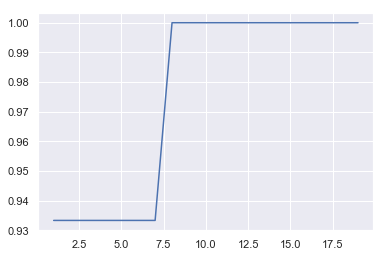

In [8]:
X_train = iris_X[indices[:-15]]
y_train = iris_y[indices[:-15]]
X_test = iris_X[indices[-15:]]
y_test = iris_y[indices[-15:]]
a_s = []
for k in range(1,20):
    p = KNeighborsClassifier(n_neighbors=k)
    p.fit(X_train, y_train)
    pred = p.predict(X_test)
    a_s.append(accuracy_score(y_test, pred))
plt.plot(range(1,20), a_s)

For some reason, 8 seems to be the best parameter.

The fact that there is an accuracy of 1 shows that either the dataset is too small or that what we are trying to predict has an easily expressed structure, which is probably the case here.

## Other classifiers than knn ##

Let's first use a decision tree.

### Decision tree ###

In [9]:
from sklearn import tree
t = tree.DecisionTreeClassifier()
t.fit(X_train, y_train)
accuracy_score(y_test, t.predict(X_test))

0.9333333333333333

Then, how about a gaussian naive Bayes.

### Gaussian Naive Bayes ###

In [10]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(iris.data, iris.target)
accuracy_score(y_test, gnb.predict(X_test))

0.9333333333333333

### Cross-evaluation of the three methods ###

In [11]:
from sklearn.model_selection import cross_val_score
print("knn:   ", np.average(cross_val_score(KNeighborsClassifier(n_neighbors=8), iris_X, iris_y, cv=9, n_jobs=5)))
print("tree:  ", np.average(cross_val_score(t, iris_X, iris_y, cv=9, n_jobs=5)))
print("Bayes: ", np.average(cross_val_score(gnb, iris_X, iris_y, cv=9, n_jobs=5)))

knn:    0.9666666666666666
tree:   0.9543209876543209
Bayes:  0.9543209876543209


Without any fine tuning and a rather small dataset, the tree & gausian naive Bayes give the exact same average accuracy, which is slightly smaller than that of the knn.

## Custom Majority Class Classifier ##

In [12]:
class clf:
    def fit(self, X, Y):
        self.c = np.bincount(Y).argmax()
        return self

    def predict(self, X):
        return np.full((len(X),), self.c)

In [13]:
foo = clf()
foo.fit(X_train, y_train)
print(foo.predict(X_test))
print(np.unique(y_train, return_counts=True))

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
(array([0, 1, 2]), array([45, 44, 46]))


The majority class depends on the split: the dataset has exactly 50 measures of each class. Here, the class 2 has indeed slightly more elements than the other, hence the prediction.

In [26]:
class better_clf:
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
        self.c = np.bincount(Y).argmax()
        return self

    def predict(self, X):
        ret = np.full((len(X),), self.c)
        for i in range(len(X)):
            l = X[i]
            y = self.Y[(l == self.X).all(axis=1)]
            if np.size(y) != 0:
                ret[i] = y[0]
        return ret

This new classifier acts as follows:
* If the observation x was met during training, then the corresponding y is returned.
* Else, return the majority class.
It is slightly better than the majority class, but this only makes a difference if we have to predict an observation that was already met. Here, is doesn't change anything:

In [29]:
bar = better_clf()
bar.fit(X_train, y_train)
bar.predict(X_test)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

However, to pick a pathological case:

In [33]:
print("better classifier: ", accuracy_score(y_train, bar.predict(X_train)))
print("majority class: ", accuracy_score(y_train, foo.predict(X_train)))

better classifier:  1.0
majority class:  0.34074074074074073
